# Transformer recipe generator analysis

Note: This notebook is designed to run with CPU (no GPU) runtime.

Install Huggingface libraries to use the pretrained tokenizer.

**You can igore the error message like `ERROR: pip's dependency resolver does not currently take into account...`.**

In [17]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Install Google Translate library to convert generated texts to other languages.

In [18]:
pip install -q googletrans==4.0.0-rc1

Import modules and set random seeds.

In [19]:
import os, random
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, saving
from googletrans import Translator

random.seed(20230629)
np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [20]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

print(f'Vocabulary size: {VOCAB_SIZE}')

Vocabulary size: 30522


Dfiner the Transformer encoder block.

In [21]:
@saving.register_keras_serializable()
class Embeddings(layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim, **kwargs):
        super(Embeddings, self).__init__(**kwargs)
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(vocab_size, embed_dim)
        self.pos_emb = layers.Embedding(max_len, embed_dim)
        self.ln = layers.LayerNormalization(epsilon=1e-12)
        self.dropout = layers.Dropout(rate=0.5)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[-1]
        position_ids = tf.range(start=0, limit=seq_len, delta=1)
        position_embeddings = self.pos_emb(position_ids)
        token_embeddings = self.token_emb(inputs)

        # Add positional embeddings
        embeddings = token_embeddings + position_embeddings
        embeddings = self.ln(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

    def build(self, input_shape):
        pass

    def get_config(self):
        config = super().get_config()
        config.update({
            'max_len': self.max_len,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
        })
        return config

Define the Transformer model consisted of a single Transformer encoder blocks.

In [22]:
@saving.register_keras_serializable()
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, key_dim, embed_dim, ff_dim, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim)
        self.dropout_1 = layers.Dropout(rate=0.1)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation='relu')
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(rate=0.1)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Multi-head attention
        attention_output, attention_scores = self.attn(
            inputs, inputs, inputs, # Inputs for Query, Value, Key
            use_causal_mask=True,
            return_attention_scores=True)
        attention_output = self.dropout_1(attention_output)
        attention_output = attention_output + inputs # Skip connection
        attention_output = self.ln_1(attention_output)

        # Feed forward
        ffn_1 = self.ffn_1(attention_output)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        ffn_output = ffn_output + attention_output # Skip connection
        ffn_output = self.ln_2(ffn_output)
        return (ffn_output, attention_scores)

    def build(self, input_shape):
        pass

    def get_config(self):
        config = super().get_config()
        config.update({
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
        })
        return config

Mount the google drive and load the trained model.

In [23]:
from google.colab import drive
drive.mount('/content/gdrive')

model_file = '/content/gdrive/My Drive/Transformer_attention_scores.keras'
attention_scores_model = saving.load_model(model_file)
attention_scores_model.summary()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Model: "Transformer_attention_scores"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_embedding (Embeddings)          │ (None, None, 512)           │      15,693,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Transformer (TransformerBlock)       │ [(None, None, 512), (None,  │       3,152,384 │
│                                      │ 4, None, None)]             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Dense)                      │ (None, None, 30522)         │      15,657,786 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,503,482 (131.62 MB)

 Trainable params: 34,503,482 (131.62 MB)

 Non-trainable params: 0 (0.00 B)

Define a function to generate new texts.

In [24]:
def sample_from(probs, temp):
    probs = probs ** (1 / temp)
    probs = probs / np.sum(probs)
    return np.random.choice(len(probs), p=probs), probs


def gen_text(prompt, temp=0.1, lang='en'):
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]
    answer = prompt
    print(answer, end='')

    c = 1
    for i in range(512):
        probs, _ = attention_scores_model.predict(np.array([input_ids]), verbose=0)
        next_token, _ = sample_from(probs[0][-1], temp)
        input_ids = np.append(input_ids, next_token)

        next_word = tokenizer.convert_ids_to_tokens([next_token])[0]
        if next_word == '[SEP]':
            break
        if next_word.startswith('##'):
            next_word = next_word[2:]
        elif next_word not in ['.', ',', ':', ';', '?', '!']:
            next_word = ' ' + next_word
        print(next_word, end='')
        answer += next_word
        if len(answer) > c * 100:
            c += 1
            print('')
    print('')

    if lang == 'en':
        return answer

    translator = Translator()
    translated = translator.translate(answer, dest=lang);
    return translated.text

Generate some sample texts.

In [25]:
gen_text('Recipe for beef', temp=1.0, lang='ja')

Recipe for beef kushiyaki: heat oil in a large skillet over medium - high heat. cook and stir the ground
 beef in the hot oil until browned, 5 to 7 minutes; drain the onion, cilantro, cajun seasoning, cum
in, kosher salt, and chili powder; cook and stir until the onions are softened and is lightly browne
d, about 5 minutes. mix in the jalapeno peppers, and curry powder into the chili powder, and water
. bring to a boil over medium heat; reduce heat to medium and simmer until flavors blend, about 10 minutes
. reduce


'牛肉のレシピクシヤキ：中程度の強火で大きなフライパンのオイルを熱します。5〜7分茶色になるまで熱い油で牛ひき肉を調理してかき混ぜます。タマネギ、コリアンダー、ケイジャン調味料、クミン、コーシャソルト、チリパウダーを排出します。玉ねぎが柔らかくなり、約5分間軽く茶色になるまで調理してかき混ぜます。ハラペーニョペッパーとカレーパウダーをチリパウダーと水に混ぜます。中火で沸騰させます。熱を中程度に減らし、フレーバーがブレンドするまで約10分間煮ます。減らす'

In [26]:
gen_text('Recipe for beef', temp=0.5, lang='ja')

Recipe for beef broccoli slaw: in a skillet, heat oil, and saute onion, and garlic in the hot oil until
 fragrant, about 1 minute. add broccoli, broccoli, and carrot; cook and stir until vegetables are tender
, about 5 minutes. stir in coconut milk and corn. stir in broccoli. bring to a boil. reduce heat
 and simmer until liquid has been absorbed, 15 to 20 minutes. add broccoli, corn, and corn; cook for
 about 5 minutes. stir in broccoli, corn, and corn; cook until the brocco


'ビーフブロッコリーのスローのレシピ：フライパン、熱油、タマネギ、玉ねぎ、ニンニク、約1分間、香りがするまでガーリック。ブロッコリー、ブロッコリー、ニンジンを加えます。野菜が柔らかくなるまで約5分間調理してかき混ぜます。ココナッツミルクとトウモロコシをかき混ぜます。ブロッコリーをかき混ぜます。沸騰させます。熱を減らし、液体が吸収されるまで15〜20分間煮ます。ブロッコリー、トウモロコシ、トウモロコシを追加します。約5分間調理します。ブロッコリー、トウモロコシ、トウモロコシをかき混ぜます。ブロッコまで調理します'

In [27]:
gen_text('Recipe for beef', temp=0.1, lang='ja')

Recipe for beef kushiyaki: heat the olive oil in a skillet over medium heat. add the onion, garlic, and
 cook until the onion has softened and turned translucent, about 5 minutes. add the venison, and cook
 for about 5 minutes. add the rice, and cook until the onion has softened and turned translucent,
 about 5 minutes. stir in the rice, tomato paste, and cook until the onion has softened and turned translucent
, about 5 minutes. stir in the chicken broth, and bring to a boil. reduce heat to medium -
 low, cover, and simmer until rice is tender,


'牛肉のレシピクシヤキ：中火でフライパンでオリーブオイルを加熱します。タマネギ、ニンニクを加え、タマネギが柔らかくなり、半透明になるまで約5分間調理します。鹿肉を加え、約5分間調理します。ご飯を加え、タマネギが柔らかくなり、半透明になるまで約5分間調理します。米、トマトペーストをかき混ぜ、玉ねぎが柔らかくなり、半透明になるまで約5分間調理します。チキンスープをかき混ぜ、沸騰させます。熱を中程度に減らす - 低く、覆い、ご飯が柔らかくなるまで煮る、'

In [28]:
gen_text('Recipe for apple', temp=1.0, lang='ja')

Recipe for apple almond muffins: preheat oven to 350 degrees f ( 175 degrees c ). grease 24 muffin cups
. in a large bowl, combine the flour, salt, and baking powder. stir together flour, baking soda, and
 salad blend egg. pour or in cold oil and stir until combined. spoon batter into prepared muffin pan
. bake in the preheated oven for 15 minutes, until a toothpick inserted into the center of the muffin
 comes out clean, about 15 minutes. cool to marry make bars.


'Apple Almond Muffinsのレシピ：オーブンを350度F（175度C）に予熱します。グリース24マフィンカップ。大きなボウルに、小麦粉、塩、ベーキングパウダーを混ぜます。小麦粉、重曹、サラダブレンド卵を一緒にかき混ぜます。注ぐかコールドオイルでかき混ぜ、混ぜ合わせるまでかき混ぜます。調製したマフィンパンにスプーンバッター。予熱したオーブンで15分間焼きます。マフィンの中央に挿入されたつまようじが清潔になるまで、約15分間きれいになります。クールな結婚はバーを作ります。'

In [29]:
gen_text('Recipe for apple', temp=0.5, lang='ja')

Recipe for apple bread pudding: preheat oven to 350 degrees f ( 175 degrees c ). grease an 8x8 - inch
 baking dish. sift together the flour, baking powder, and salt. set aside. in a large bowl, beat the
 eggs, eggs, and vanilla extract together in a bowl until smooth. stir in the flour mixture, and pour
 into the prepared baking dish. bake in the preheated oven for 45 minutes, until a knife inserted into
 the center of the loaf comes out clean, about 45 minutes.


'リンゴパンプディングのレシピ：オーブンを350度F（175度C）に予熱します。8x8 -インチのベーキング皿にグリースを塗ります。小麦粉、ベーキングパウダー、塩を一緒にふるいにかけます。脇に置いてください。大きなボウルで、卵、卵、バニラの抽出物を滑らかになるまでボウルに抽出します。小麦粉の混合物をかき混ぜ、準備したベーキング皿に注ぎます。パンの中央に挿入されたナイフが清潔になるまで、約45分間、予熱したオーブンで45分間焼きます。'

In [30]:
gen_text('Recipe for apple', temp=0.1, lang='ja')

Recipe for apple cinnamon rolls: preheat oven to 350 degrees f ( 175 degrees c ). grease a 9x13 inch baking
 dish. in a large bowl, mix together the flour, baking powder, baking soda, and salt. set aside
. in a large bowl, mix together the eggs, oil, and vanilla extract. stir in the flour mixture, mixing
 just until moistened. fold in the raisins, and walnuts. pour the batter into the prepared pan. ba
ke in the preheated oven for 45 minutes, or until a toothpick inserted into the center of the cake comes
 out clean


'アップルシナモンロールのレシピ：オーブンを350度F（175度C）に予熱します。9x13インチのベーキング皿にグリースを塗ります。大きなボウルに、小麦粉、ベーキングパウダー、重曹、塩を混ぜます。脇に置いてください。大きなボウルに、卵、油、バニラの抽出物を混ぜます。小麦粉の混合物をかき混ぜ、湿らせるまで混合します。レーズンとクルミを折ります。準備されたパンにバッターを注ぎます。予熱したオーブンで45分間焼くか、ケーキの中央に挿入されたつまようじがきれいになるまで焼きます'

Show attention weights (averaged over multiple attention heads) for the Transformer encoder layers.

In [31]:
prompts = [
    'recipe for chicken breasts : mix the garlic powder with',
    'recipe for beef steak: bring a large pot of'
]

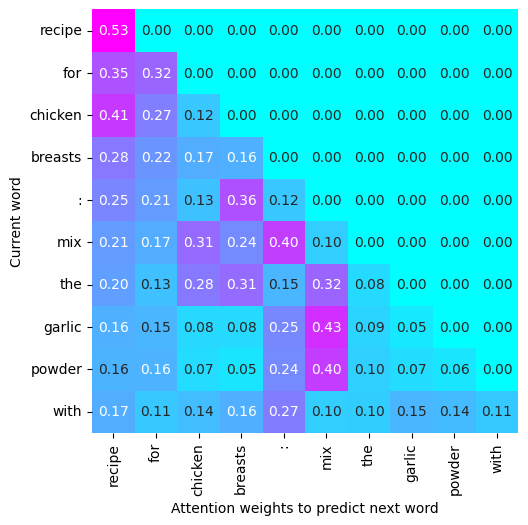

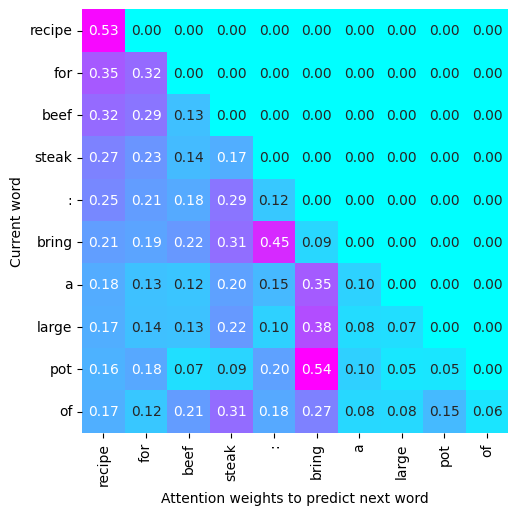

In [32]:
import seaborn as sns

for prompt in prompts:
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]
    _, attention_scores = attention_scores_model.predict(
                                np.array([input_ids]), verbose=0)
    labels = tokenizer.convert_ids_to_tokens(input_ids)
    text_len = attention_scores.shape[-1]

    fig = plt.figure(figsize=(text_len/2, text_len/2))
    subplot = fig.add_subplot(1, 1, 1)
    heatmap = sns.heatmap(
        np.max(attention_scores[0, :, 1:text_len, 1:text_len], axis=0),
        ax = subplot,
        cmap='cool', cbar=False, annot=True, fmt='1.2f')
    heatmap.set_xticklabels(labels[1:text_len], rotation = 90)
    heatmap.set_yticklabels(labels[1:text_len], rotation = 0)
    _ = heatmap.set(xlabel='Attention weights to predict next word',
                    ylabel='Current word')